# Attention Explainer Visualizations and Interpretations

In [1]:
%load_ext autoreload
%autoreload 2

from src.models.gps import GPS
from src.models.gcn import GCN
from src.models.explainer.explainer_pipeline import ExplainerPipeline
from src.models.explainer.gnn_explainer import GNNExplainer
from src.data import loader

import networkx as nx

from torch_geometric.explain import ModelConfig

## BA Shapes

The graph shown below is one of our benchmark synthetic datasets, BA shapes.

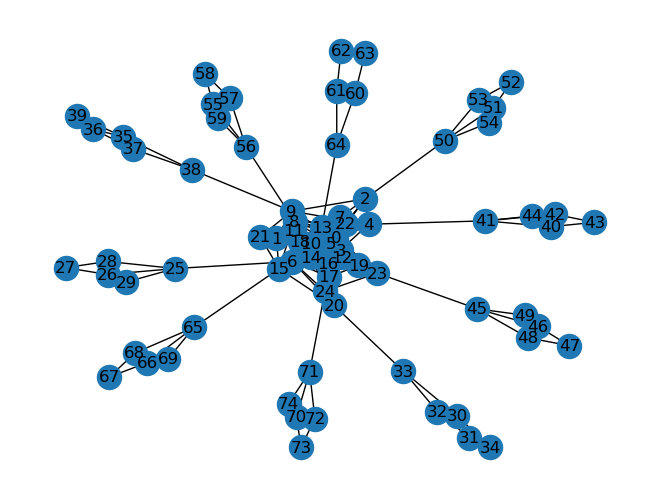

In [3]:
data, num_classes, data_networkx = loader.load_clean_bashapes(num_nodes=25, num_edges=5, num_motifs=10, laplacian_eigenvector_dimensions=2)
nx.draw(data_networkx, with_labels=True)

In [5]:
gps_params = {
    'pe_channels': 2,
    'num_layers': 4,
    'hidden_channels': 4,
    'num_attention_heads': 1,
    'observe_attention': True
}

gcn_params = {
    "hidden_channels": 20,
    "num_layers": 3
}

explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    )
}

explainer_pipeline = ExplainerPipeline(data, num_classes, GCN, GNNExplainer, model_params=gcn_params, explainer_params=explainer_params, epochs=4000)
explainer_pipeline.get_accuracies()

100%|██████████| 4000/4000 [00:11<00:00, 346.17it/s]

Train accuracy: 0.8333333333333334
Test accuracy: 0.8


In [6]:
from src.models.utils.hooks import GPSHook
from src.models.model import train, test

gps = GPS(data, num_classes, **gps_params)
hook = GPSHook(gps)
train(gps, data, epochs=2)
hook.remove_hooks()
hook.attention_weights

100%|██████████| 2/2 [00:00<00:00, 21.63it/s]


{0: tensor([[[0.0133, 0.0133, 0.0132,  ..., 0.0131, 0.0131, 0.0131],
          [0.0133, 0.0133, 0.0132,  ..., 0.0131, 0.0131, 0.0131],
          [0.0133, 0.0133, 0.0133,  ..., 0.0131, 0.0131, 0.0131],
          ...,
          [0.0133, 0.0133, 0.0133,  ..., 0.0131, 0.0131, 0.0131],
          [0.0133, 0.0133, 0.0133,  ..., 0.0131, 0.0131, 0.0131],
          [0.0133, 0.0133, 0.0133,  ..., 0.0131, 0.0131, 0.0131]]]),
 1: tensor([[[4.0605e-06, 7.2806e-02, 3.2511e-03,  ..., 2.3884e-03,
           1.4826e-03, 4.3725e-03],
          [1.0545e-01, 8.8917e-04, 4.0330e-03,  ..., 4.7589e-03,
           6.0019e-03, 3.5421e-03],
          [7.2890e-03, 1.7575e-02, 1.3076e-02,  ..., 1.3750e-02,
           1.3178e-02, 1.4516e-02],
          ...,
          [3.1947e-02, 6.7235e-03, 1.0982e-02,  ..., 1.2054e-02,
           1.3013e-02, 1.0962e-02],
          [2.2552e-02, 9.0206e-03, 1.2015e-02,  ..., 1.2960e-02,
           1.3562e-02, 1.2264e-02],
          [5.0426e-02, 4.0991e-03, 9.0638e-03,  ..., 1.0173e

In [7]:
#generate heatmaps for attention matrices

import matplotlib.pyplot as plt
import seaborn as sns

def attention_weights_heatmap(attention_matrices, show_all_layers=False):

    if show_all_layers:
        for layer in attention_matrices:
            plt.figure(figsize=(10, 8))
            sns.heatmap(attention_matrices[layer][0], cmap='viridis', annot=False)
            plt.title(f"Attention Heat Map for Layer {layer}")
            plt.xlabel("Source Nodes")
            plt.ylabel("Attention Given")
            plt.show()
    
    #if else, only show the heatmap for the attention matrix of the last layer
    else:
        last_layer_index = list(attention_matrices.keys())[-1]
        plt.figure(figsize=(10, 8))
        sns.heatmap(attention_matrices[last_layer_index][0], cmap='viridis', annot=False)
        plt.title(f"Attention Heat Map for Final Layer ({last_layer_index})")
        plt.xlabel("Source Nodes")
        plt.ylabel("Attention Given")
        plt.show()

To gain more insight into our model's decision making on BA shapes, we've visualized the attention matrices for each layer of our graph transformer (4 total). The Source Nodes (horizontal axis) are paying attention to the nodes on the vertical axis, titled Attention Given.

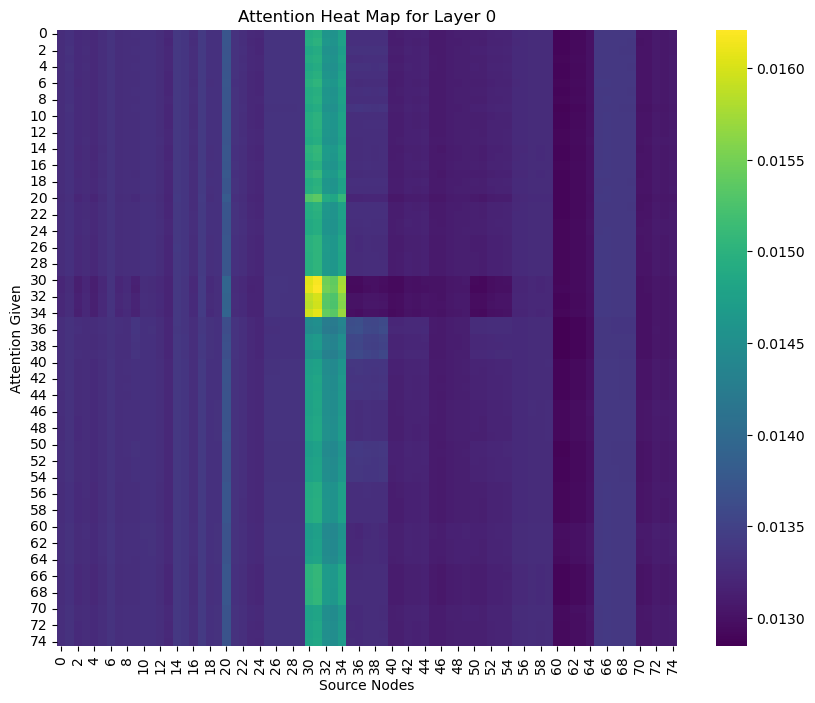

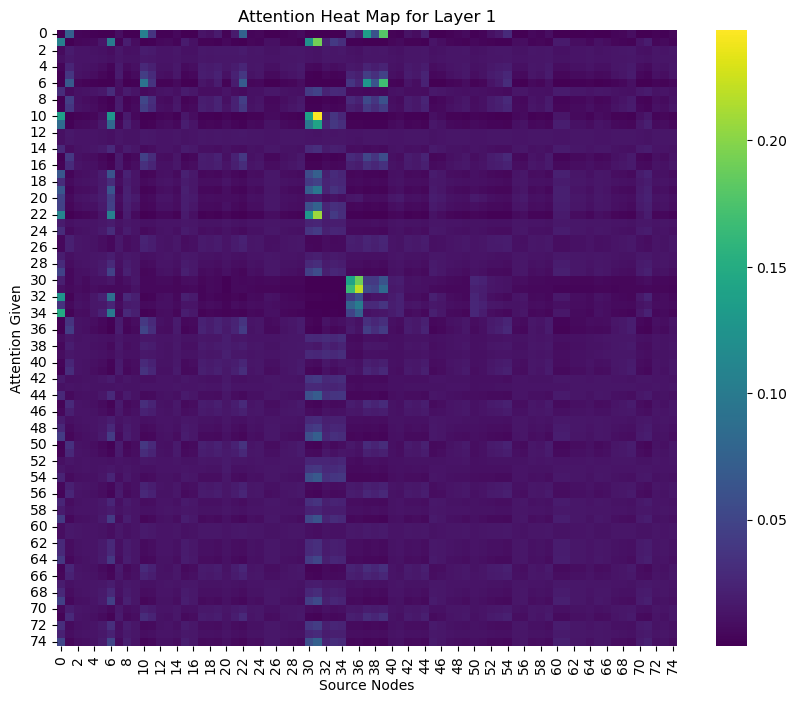

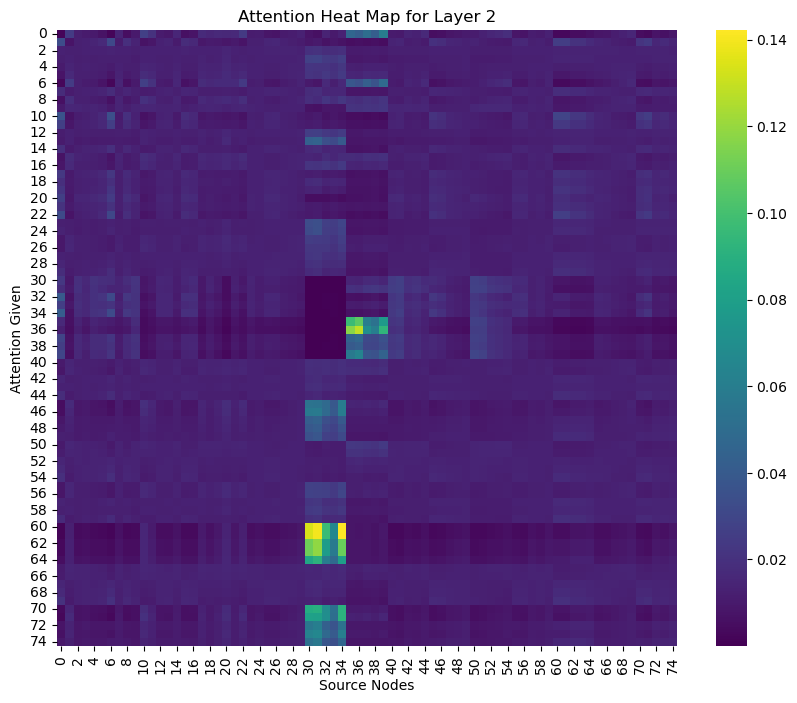

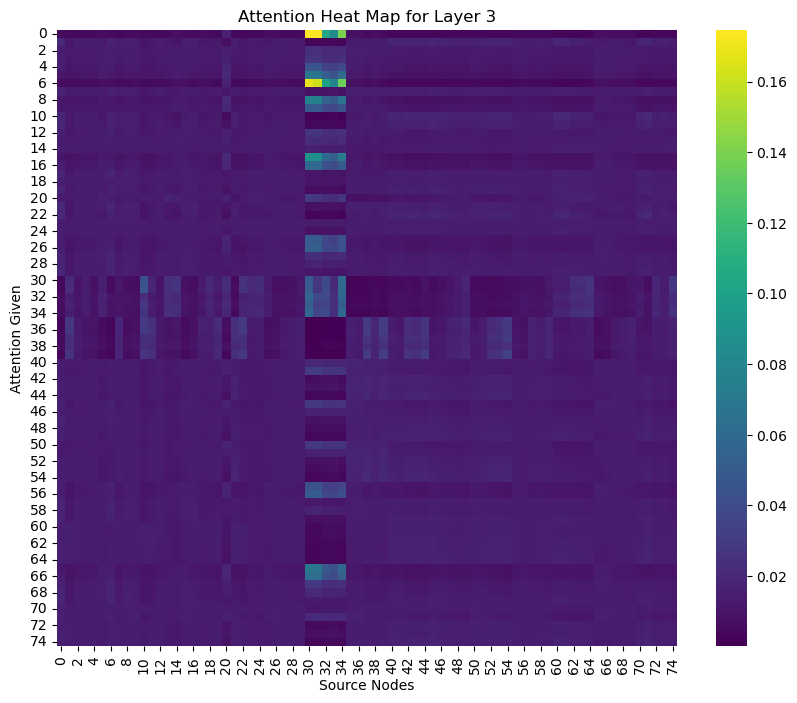

In [8]:
attention_weights_heatmap(hook.attention_weights, show_all_layers=True)

As we can see, as we move from layer to layer, the attention given seems to become more concentrated within certain nodes, and there are blocks of nodes where more attention is paid, converging on a possible explanation. It seems that the nodes within the range of 30-40 are paying a lot of attention to nodes near them for those specific predictions.

## PascalVOC-SP

Now we will look towards another benchmark dataset, PascalVOC-SP.

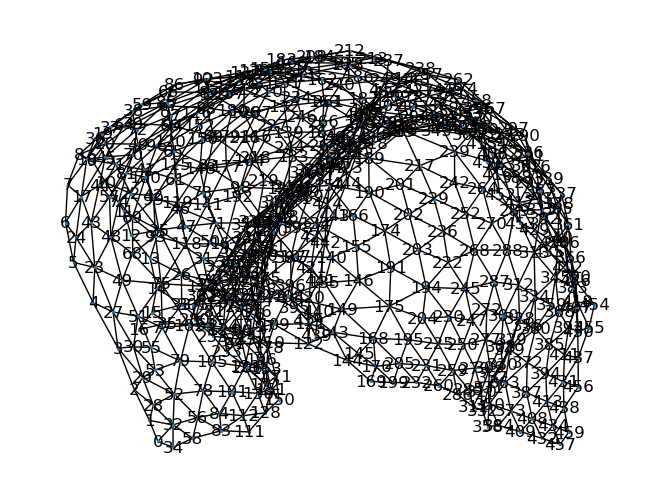

In [9]:
pascalvoc_sp, pascalvoc_sp_num_classes, pascal_voc_sp_data_networkx = loader.load_clean_pascalvoc_sp(3)
nx.draw(pascal_voc_sp_data_networkx, with_labels=True, node_size=2)

In [10]:
model_params={
            'pe_channels': 5,
            'num_layers': 2,
            'hidden_channels': 4,
            'num_attention_heads': 1,
            'observe_attention': True
        }


gps = GPS(pascalvoc_sp, pascalvoc_sp_num_classes, **model_params)
hook = GPSHook(gps)
train(gps, pascalvoc_sp, epochs=500)
hook.remove_hooks()
hook.attention_weights

100%|██████████| 500/500 [00:07<00:00, 69.68it/s]


{0: tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.9323e-12],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 8.1332e-31],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]]),
 1: tensor([[[2.8798e-01, 1.2808e-01, 6.7102e-02,  ..., 2.4412e-17,
           4.0254e-17, 8.8077e-17],
          [2.1896e-01, 1.1134e-01, 6.5529e-02,  ..., 2.8897e-14,
           4.6037e-14, 8.8699e-14],
          [1.8753e-01, 1.0109e-01, 6.2662e-02,  ..., 7.1680e-13,
           1.1312e-12, 2.0636e-12],
          ...,
          [2.4701e-02, 2.1437e-02, 1.8752e-02,  ...,

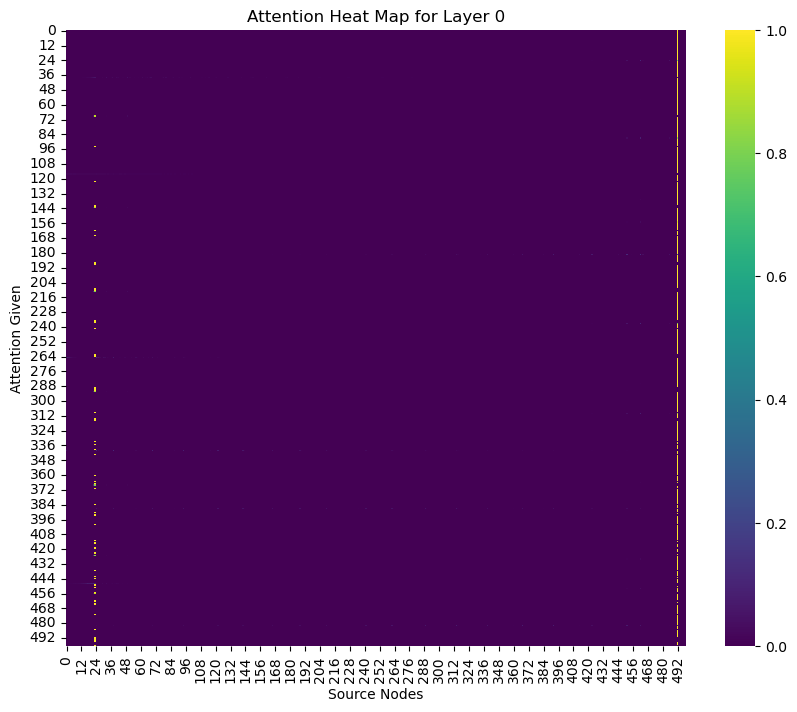

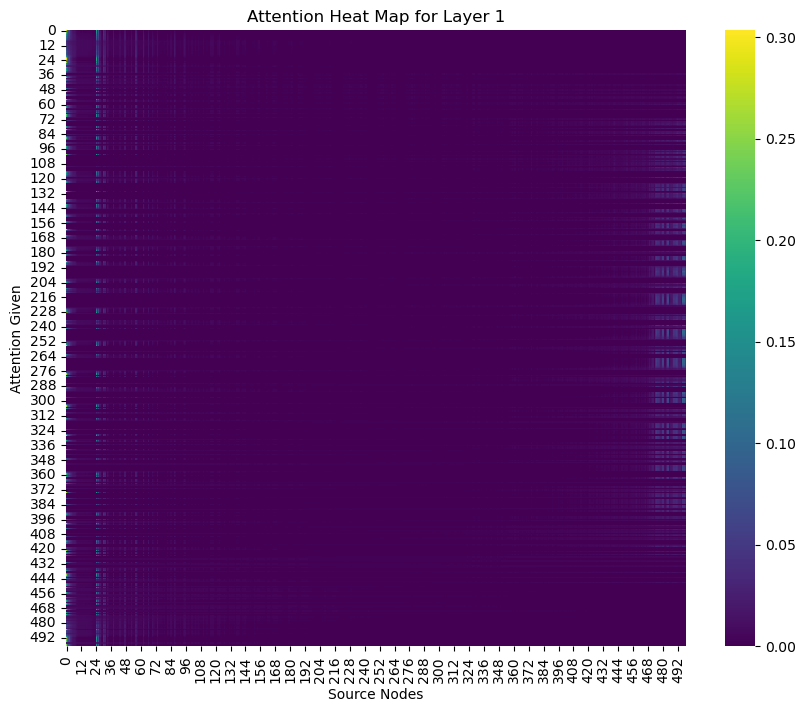

In [11]:
attention_weights_heatmap(hook.attention_weights, show_all_layers=True)

For PascalVOC-SP, the heatmaps seems to be less intuitive, but there seems to be attention being paid from the nodes near 24 and towards the end at 492, with the second layer expanding on that range and making it less condensed.